# Baseline Model

Enable auto-reloading of external modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dependencies

In [2]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [4]:
X_data_load, y_data = ACSDataLoader(task=DATASET_CONFIG['task'], state=DATASET_CONFIG['state'], year=DATASET_CONFIG['year'])

In [5]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [6]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best baseline model

baseline_X_train shape:  (157573, 16)
baseline_X_test shape:  (39394, 16)
Tuning for LogisticRegression is finished
####################  Folktables [NY 2018]  ####################
Test model:  LogisticRegression
Test model parameters:
{'max_iter': 50, 'penalty': 'none', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0      0.832     0.722     0.773     21095
           1      0.722     0.832     0.773     18299

    accuracy                          0.773     39394
   macro avg      0.777     0.777     0.773     39394
weighted avg      0.781     0.773     0.773     39394



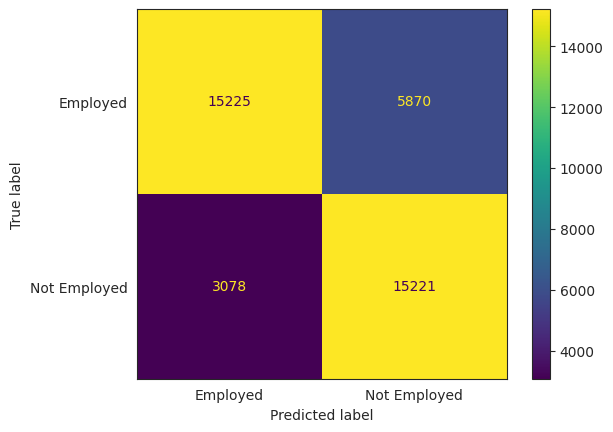

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.869     0.788     0.826     21095
           1      0.779     0.863     0.819     18299

    accuracy                          0.822     39394
   macro avg      0.824     0.825     0.822     39394
weighted avg      0.827     0.822     0.823     39394



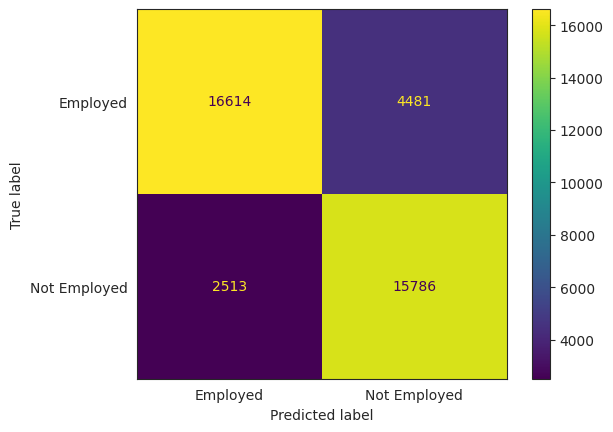

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.866     0.805     0.834     21095
           1      0.792     0.856     0.823     18299

    accuracy                          0.829     39394
   macro avg      0.829     0.831     0.829     39394
weighted avg      0.832     0.829     0.829     39394



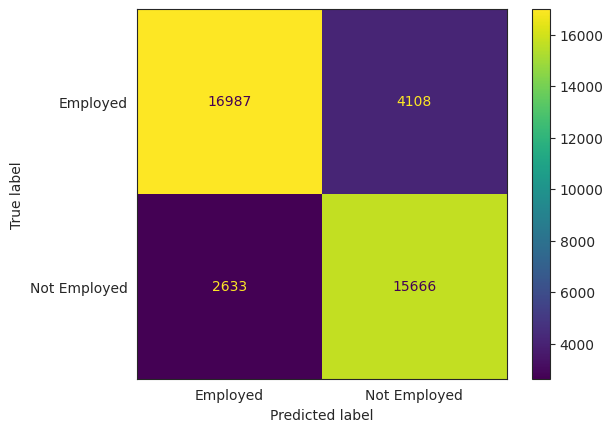

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.772859,0.772859,"{'max_iter': 50, 'penalty': 'none', 'solver': ..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.822382,0.822460,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,Folktables [NY 2018],XGBClassifier,0.828690,0.828883,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [7]:
# Copy datasets for tuning to avoid confusion with datasets for imputations
baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)

ML_baseline_results_df = test_baseline_models(baseline_X_data, baseline_y_data)
ML_baseline_results_df

In [8]:
for index, row in ML_baseline_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 50, 'penalty': 'none', 'solver': 'lbfgs'}


Model name: DecisionTreeClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}


In [9]:
import datetime

tz = datetime.timezone.utc
ft = "%Y_%m_%dT%H_%M_%S%z"
t = datetime.datetime.now(tz=tz).strftime(ft)

ML_baseline_results_df.to_csv(os.path.join('..', 'results', f'ML_baseline_results_df_{t}.csv'),
                              sep=",", columns=ML_baseline_results_df.columns, float_format="%.2f")